# RDBMS - MySQL 

## 00 - Introduction

Among the Relational DBMSs, the most widely known are Oracle, SQLite, Postgres, MariaDB, and MySQL.

Each one of them is characterized by a different set of "variations" on top of the base SQL language, although usually minor.

We will use **MySQL** to run exercises about Relational DB transactions using the SQL language, as it is *currently* at the top of the list of most widely used RDBMSs. 

[DB Engines Ranking Trend](https://db-engines.com/en/ranking_trend/relational+dbms)

[Worldwide Popularity Ranking of Database Management Systems](https://www.statista.com/statistics/809750/worldwide-popularity-ranking-database-management-systems/)

[Stack Overflow 2023 Developer Survey - Most Popular Technologies (Language)](https://survey.stackoverflow.co/2023/#most-popular-technologies-language)

[Stack Overflow 2023 Developer Survey - Most Popular Technologies (Database)](https://survey.stackoverflow.co/2023/#most-popular-technologies-database)


MySQL programming interfaces exist for many languages, including C, C++, Go, Java, Perl, PHP, Python, etc...

Even simply referring to Python, we can count on several options to connect and interact with the DBs. 

Let's explore a couple of them...

## 01 - Create a Connection to MySQL

A MySQL server is running within one of your Docker containers.

You can access it using the MySQL server credentials defined in the `docker-compose.yml` file.

By default, a `root` user is created with the following credentials:
- **Username:** `root`
- **Password:** `root_pwd`

Additionally, a non-`root` user is created by default with:
- **Username:** `my_user`
- **Password:** `my_pwd`


#### Interactive

To interact with the MySQL server, you can log in interactively to its Docker container.

First, check the `CONTAINER ID` of the container named `mysql_db` by running:

```bash
$ docker ps
```

Then, initiate an interactive bash session within the container by executing:

```bash
$ docker exec -it <YOUR CONTAINER ID> bash
```

Once inside the container, you can access the MySQL server as if you were connected to a remote server hosting your databases:

```bash
$ mysql -u <EITHER ROOT OR USER> -p
```

Replace `<YOUR CONTAINER ID>` with the actual container ID obtained from the `docker ps` command output, and `<EITHER ROOT OR USER>` with either `root` or `my_user`, depending on the user you want to log in as.



We can then inspect the MySQL server to display all databases by executing the following SQL command:

```mysql
SHOW DATABASES;
```

**NB**: Remember to end a SQL command with a semicolon `;`.

#### mysql.connector

A more pythonic way to interact with a MySQL server is by using a dedicated driver such as `mysql.connector`, which is already installed in the Jupyter Notebook container.

This connector offers an interface to establish a connection object to the MySQL server and provides various functionalities for executing transactions and fetching records from databases.

We can start by declaring a connection to our MySQL server.

**NB:** The server is hosted in a different container from the notebook, simulating a connection between two different machines: a client and a server.


In [1]:
# import the connector
import mysql.connector

# declare a connection to the MySQL server 
# the hostname (or IP) of the server machine should be passed
db = mysql.connector.connect(
  user="root",
  password="root_pwd",
  host="db", # in this case 'db' is the equivalent of the IP address of the server 
             # or 'localhost' if running mysql locally
)

print(db)

At this point, a database connection is established.

To interact with the database using Python and `mysql.connector`, we need a "handle" known as a cursor, which must be instantiated.

When using this connector to interact with the database, all SQL statements are executed using the cursor.


In [2]:
# create our db cursor object
dbc = db.cursor()

The cursor allows us to execute all SQL transactions on the database as if we were logged into the server.

If a transaction fetches results from the database (returns a set of records), the connector object will retain the results. This feature can be useful for later use in a more "pythonic" way, integrating our database queries with other Python statements.

The syntax for issuing a generic SQL statement is as follows:

```python
connector_object.execute(my_sql_query)
```

For example, let's execute the same check as before by asking MySQL to show us all available databases...

In [3]:
# show all available databases
dbc.execute(
"SHOW DATABASES"
)

No output is printed because the result of this SQL transaction is collected into the cursor as a list of records (tuples).

To retrieve the results, we can simply loop over them.

In [4]:
# loop over the container to fetch the results
for _ in dbc:
    print(_)

('information_schema',)
('mysql',)
('performance_schema',)
('sys',)


If we are `root` users in this example, we can access the inner structure of the MySQL server, which already contains a few databases by default.

After fetching the output of the transaction, the cursor reaches "the end" of the records and becomes available to perform a new transaction.

In [5]:
# use fetch to retrieve one, many, or all entries in the cursor
dbc.fetchone()

# dbc.fetchmany(2)

# dbc.fetchall()

If one wants to perform a new transaction without collecting the output of the previous one from the cursor, a reset must be issued first:

```python
connector_object.reset()
```

If a generic user (i.e., not the `root` user) is logged into the database server, they will not have access to certain functionalities and won't be able to see the previous list of all databases.

Some of these databases and tables are protected and used to store additional information about the state of the MySQL server and the connected users.

In [6]:
# connecto to the database as a non-root user
udb = mysql.connector.connect(
  user="my_user",
  password="my_pwd",
  host="db",
)

# create a cursor
udbc = udb.cursor()

# execute the transaction
udbc.execute(
"SHOW DATABASES"
)

# fetch all results
udbc.fetchall()

[('information_schema',), ('performance_schema',)]

#### iPython Magic

Another way to execute queries from Python within a Jupyter Notebook is by utilizing notebook "magic" functions, which are based on iPython and SQLAlchemy.

This approach is similar to loading inline figures from Matplotlib using `%matplotlib inline`.

To instruct iPython to interpret SQL commands and connect to the appropriate database, we need to:

1. Load the extension for the SQL language.
2. Set the environment variable to point to the connection to the database.


In [7]:
%load_ext sql

%env DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db

env: DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db


Now, notebook cells can execute SQL transactions directly in plain SQL by starting the cell with `%%sql`.

By default, the result is also printed using the `pretty` format, similar to the pandas-like format.

In [8]:
%%sql

SHOW DATABASES;

6 rows affected.


Database
IMDb
information_schema
mysql
performance_schema
sys
world


An additional benefit is that a single `%sql` (not a double `%%sql`) can be used to combine a SQL query with any Python command.

In [9]:
my_python_var = %sql SHOW DATABASES

print(my_python_var)

 * mysql+mysqlconnector://root:***@db
4 rows affected.
+--------------------+
|      Database      |
+--------------------+
| information_schema |
|       mysql        |
| performance_schema |
|        sys         |
+--------------------+


The combination of either of the two Pythonic methods can be used to easily redirect the output of database transactions to leverage other well-known Python modules, such as plotting with Matplotlib.

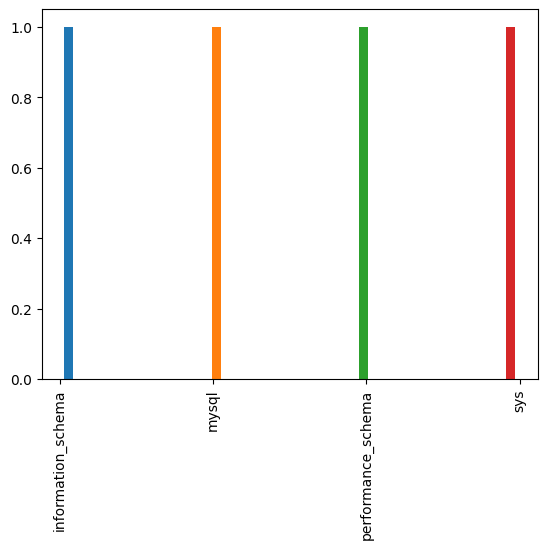

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(my_python_var);
plt.xticks(rotation='vertical');

## 02 Database and Table creation

We have already seen how to inspect the server to see which databases are present using the command:

```mysql
SHOW DATABASES;
```

To start interacting with a specific database, we can select it using `USE`:

```mysql
USE <DB_NAME>;
```

If the user has been granted the right to access this database, it's possible to start investigating its content.

If we want to create a new database to work with instead, we can use the command:

```mysql
CREATE DATABASE <DB_NAME>;
```

A more complex syntax can be used to create a new database only if no other database with the same name already exists:

```mysql
CREATE DATABASE IF NOT EXISTS <DB_NAME>;
```

- Check if a DB named `my_db` exists.
- If not, create one. 
- Then, switch to the new DB to start using it.

In [11]:
%%sql 

CREATE DATABASE IF NOT EXISTS my_db;
USE my_db;

 * mysql+mysqlconnector://root:***@db
1 rows affected.
0 rows affected.


[]

All tables contained in the DB are shown in a similar way to what used to show all DBs on the server:

```mysql
SHOW TABLES;
```

**NB**: we are inspecting the content of a specific DB (the one selected with `USE <DB_NAME>`)

In [12]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


Tables_in_my_db


The analogous Pythonic way to execute the same list of commands (using the `mysql.connector` driver) is the following:

**NB**: This time we are not retrieving results from the server, but are instead asking the DBMS to _create_ a new database. We are issuing a request that requires us to **commit** a change in the MySQL server

In [13]:
# defining the sql command line
sql_ = "CREATE DATABASE IF NOT EXISTS my_db;"

# instructing the cursor to execute it
dbc.execute(sql_)

# in this case the result of the sql transaction is not to return a list of items 
# it is instead a change in the DB structure
# therefore, for the change to have an effect, the change is to be committed to the DB
db.commit() 

All other commands discussed so far (`USE` and `SHOW`), do not require any change to be committed, therefore we can simply issue them via the cursor.

Creating new databases, or changing the structure (_schema_) or the content (_instance_) of a database, will instead require a `commit`.

In [14]:
# use the my_db database
dbc.execute("USE my_db")

# show all tables
dbc.execute("SHOW TABLES")
dbc.fetchall()

[]

So far the `my_db` database is empty, so let's use the same lines presented in the slides to create a dummy `Users` table.

Any table can then be inspected to check its schema by listing all attributes.

1. Begin by creating a `Users` table. Define the schema by specifying each attribute.
2. Verify if it has been successfully created in the database. Use the `SHOW` command for this purpose.
3. Inspect the schema of the `Users` table, execute the `DESCRIBE <TABLE_NAME>` command.

In [15]:
%%sql

# create a table following the schema on the slides
CREATE TABLE Users (
    UserID    varchar(30),
    BadgeNum  int(16),
    FirstName varchar(255),
    LastName  varchar(255),
    Age       int,
    OtherAttr float
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [16]:
%%sql

# show the tables in the current database
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


Tables_in_my_db
Users


In [17]:
%%sql

# describe the table `Users`
DESCRIBE Users;

 * mysql+mysqlconnector://root:***@db
6 rows affected.


Field,Type,Null,Key,Default,Extra
UserID,varchar(30),YES,,None,
BadgeNum,int,YES,,None,
FirstName,varchar(255),YES,,None,
LastName,varchar(255),YES,,None,
Age,int,YES,,None,
OtherAttr,float,YES,,None,


Following the previous examples, let's perform the same transactions using the `mysql.connector` driver. Since the `Users` table already exists, we will create a new table called `Users_py`.

Remember the following points:

- Utilize the DB Cursor to execute the transactions.
- Transactions that change the content of the DB must be _committed_ to the DB.
- Transactions returning the content of the DB host their results _in the cursor_.

In [18]:
# create a table following the schema on the slides
sql = 'CREATE TABLE Users_py (\
       UserID    varchar(30),\
       BadgeNum  int(16),\
       FirstName varchar(255),\
       LastName  varchar(255),\
       Age       int,\
       OtherAttr float);'
dbc.execute(sql)
db.commit()

In [19]:
# show the tables in the current database
dbc.execute("SHOW TABLES")
dbc.fetchall()

[('Users',), ('Users_py',)]

In [20]:
# describe the table `Users_py`
dbc.execute("DESCRIBE Users_py")
dbc.fetchall()

[('UserID', 'varchar(30)', 'YES', '', None, ''),
 ('BadgeNum', 'int', 'YES', '', None, ''),
 ('FirstName', 'varchar(255)', 'YES', '', None, ''),
 ('LastName', 'varchar(255)', 'YES', '', None, ''),
 ('Age', 'int', 'YES', '', None, ''),
 ('OtherAttr', 'float', 'YES', '', None, '')]

## 03 Declaring contstraints and altering tables

Before moving on, let's clean up all existing tables in our database.

To remove an existing table from the database, you can use the following instruction:

```mysql
DROP TABLE IF EXISTS <NAME OF YOUR TABLE>;
```

**CAUTION**: Dropping a table deletes all records from that table and severs all connections with other tables based on foreign keys. This action can render the entire database unusable. Be extremely careful when executing this command.

In [21]:
%%sql 

# drop the table Users
DROP TABLE IF EXISTS Users;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

Let's also drop the `Users_py` table using the Python connector.
This is once again an action that alters the database, thus we must `commit` it.

In [22]:
# drop the table Users_py
dbc.execute("DROP TABLE IF EXISTS Users_py")
db.commit()

In [23]:
# inspect the content of the database
dbc.execute("SHOW TABLES")
dbc.fetchall()

[]

Create a new `products` table with the following schema:

| Attribute    | Type    | Extra info | Constraint                |
|--------------|---------|------------|---------------------------|
| productID    | Integer |            | NOT NULL AUTO_INCREMENT  |
| productName  | String  | Max length 30 | DEFAULT ''            |
| unitPrice    | Float   |            | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned   | NOT NULL DEFAULT 0        |


The `productID` attribute will be our `PRIMARY KEY`.

This can be declared either inline, or at the end of the table definition:

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY
```

or 

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT
[...]
PRIMARY KEY (productID)
```

In [24]:
%%sql

# create the products table
CREATE TABLE IF NOT EXISTS products (
         productID    INT          NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
         productName  VARCHAR(30)  DEFAULT '' ,
         unitPrice    FLOAT        NOT NULL DEFAULT 99999.99,
         unitsInStock INT UNSIGNED NOT NULL DEFAULT 0
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [25]:
%%sql

# inspect the table schema
DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),YES,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,


The table does not contain any constraints, default values, or foreign keys.

The **schema** of a given table can be altered by adding/removing Attributes, as well as by adding constraints.

Let's first add a new attribute to the table:

| Attribute       | Type    | Extra info     | Constraint                |
|-----------------|---------|----------------|---------------------------|
| productID       | Integer |                | NOT NULL AUTO_INCREMENT  |
| productName     | String  | Max length 30  | DEFAULT ''               |
| unitPrice       | Float   |                | NOT NULL DEFAULT 99999.99|
| unitsInStock    | Integer | Unsigned       | NOT NULL DEFAULT 0       |
| **isDiscontinued** | **Bool** |              | NOT NULL                  |


To alter the **schema** of a table and create a new column we can act on it with:

```mysql
ALTER TABLE <THE TABLE>
ADD COLUMN <NEW COL> <THE NEW ATTRIBUTE DECLARATION>;
```


#### Alter the `products` table and add the `isDiscontinued` attribute

In [26]:
%%sql

# alter the table
ALTER TABLE products
ADD COLUMN isDiscontinued BOOL NOT NULL;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [27]:
%%sql

# inspect the table schema
DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),YES,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,None,


The `isDiscontinued` attribute does not contain any meaningful constraint or default value.
Let's consider `0` as a good default value for this attribute:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT '' |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL **DEFAULT 0** |

We can use the same `ALTER TABLE` instruction to do this, and set a new default:
    
```mysql
ALTER TABLE <THE TABLE>
ALTER <ATTRIBUTE> SET DEFAULT <NEW DEFAULT>;
```

In [28]:
%%sql 

# alter the table
ALTER TABLE products 
ALTER isDiscontinued SET DEFAULT 0;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [29]:
%%sql

# inspect the table schema
DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),YES,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


We can also impose `productName` to be not-null by altering the table one final time.

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | **NOT NULL** DEFAULT '' |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL DEFAULT 0 |


In MySQL, this implies modifying the entire attribute, thus the Type will have to be re-stated:
    
```mysql
ALTER TABLE <THE TABLE>
MODIFY <ATTRIBUTE> <ATTRIBUTE TYPE> <CONSTRAINT>;
```

In [30]:
%%sql

# alter the table
ALTER TABLE products
MODIFY productName VARCHAR(30) NOT NULL;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [31]:
%%sql

# inspect the table schema
DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),NO,,None,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


Let's now create a `suppliers` table with the following description:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| supplierID   | Integer | | NOT NULL AUTO_INCREMENT |
| supplierName | String | Max length 30 | NOT NULL DEFAULT "" |
| countryCode   | Char | Length 3 | NOT NULL |
| email   | String | Max length 30  | NOT NULL |

`supplierID` is going to act as the table's primary key in this case.

In [32]:
%%sql

# create the suppliers table
CREATE TABLE suppliers (
    supplierID      INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
    supplierName    VARCHAR(30) NOT NULL DEFAULT "",
    countryCode     CHAR(3) NOT NULL,
    email           VARCHAR(30) NOT NULL
);


 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [33]:
%%sql 

# inspect the table schema
DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,int,NO,PRI,None,auto_increment
supplierName,varchar(30),NO,,,
countryCode,char(3),NO,,None,
email,varchar(30),NO,,None,


Alter the table to include a default "ITA" for `countryCode`

In [34]:
%%sql 

# alter the table
ALTER TABLE suppliers 
ALTER countryCode SET DEFAULT "---";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [35]:
%%sql 

# inspect the table schema
DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,int,NO,PRI,None,auto_increment
supplierName,varchar(30),NO,,,
countryCode,char(3),NO,,---,
email,varchar(30),NO,,None,


To establish a relation between the `products` and `suppliers` tables, we have to consider that:
    
- a supplier can supply multiple products
- a product can be supplied by multiple suppliers

This is a **many-to-many** relationship, which requires a supporting external table.

To establish a many-to-many relationship between the products and suppliers tables, we create a junction table named `supplier_to_product` with foreign keys referencing the `productID` from the `products` table and the `supplierID` from the `suppliers` table.

Create a new `supplier_to_product` table with the following attributes:
    
| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| prodID   | Integer | | NOT NULL |
| supID    | Integer | | NOT NULL |


In [36]:
%%sql

# create the support table
CREATE TABLE supplier_to_product (
    prodID     INT NOT NULL,
    supID      INT NOT NULL
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

Neither `prodID` nor `supID` is a good primary key in this case, as we can have both appearing multiple times in the table.

However, a good primary key for this table is the combination `(prodID,supID)` which is unique, and thus, a good key.

We can alter the table to add the primary key statement:
    
```mysql
ALTER TABLE <TABLE>
ADD PRIMARY KEY (<ATTRIBUTE 1>, <ATTRIBUTE 2>);
```

In [37]:
%%sql

# alter the table
ALTER TABLE supplier_to_product
ADD PRIMARY KEY (prodID, supID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [38]:
%%sql 

# inspect the table schema
DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,int,NO,PRI,None,
supID,int,NO,PRI,None,


Finally, we can link the 3 tables together by stating which attributes act as the foreign keys in the `supplier_to_product` table, and to which attributes in the parent tables they refer to.

- `prodID` points to the `productID` attribute of `products` table
- `supID` points to the `supplierID` attribute of `supplier` table

This translates into:
- `prodID` is a foreign key for `supplier_to_product`
- `subID` is a foreign key for `supplier_to_product`
- the combination `(prodID, supID)` is the primary key of `supplier_to_product`

We can declare an attribute as a foreign key by altering the table:

```mysql
ALTER TABLE <TABLE>
ADD FOREIGN KEY (<ATTRIBUTE IN THIS TABLE>) REFERENCES <OTHER TABLE>(<ATTRIBUTE IN OTHER TABLE>);
```

In [39]:
%%sql 

# alter the table
ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_prod
FOREIGN KEY (prodID) REFERENCES products(productID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [40]:
%%sql 

# alter the table
ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [41]:
%%sql 

# inspect the table schema
DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,int,NO,PRI,None,
supID,int,NO,PRI,None,


## 04 Inserting Updating and Deleting records

The tables are currently empty. 
We can inspect their content by performing a simple "read" query using `SELECT`.
We will discuss later the full syntax of the `SELECT` statement... for the time being, it's important to realize that this command will show the entire content of all columns of the table we are inspecting.

```mysql
SELECT * FROM <TABLE>;
```

To insert a single record into a table we can proceed in either of the two following ways:

1. By explicitly specifying the names of the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES (<VALUE1>, <VALUE2>, <VALUE3>, ...);
```
This will work also in the case attributes with a default value will not be explicitly passed


2. By implicitly using all the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> 
VALUES (<VALUE1>, <VALUE2>, ..., <VALUEn>);
```

**NB**: 1. is the usually recommended way to perform a data insertion in SQL, as (pretty much always in coding) **explicit is better than implicit**

Using the `mysql.connector` we can formulate the same data insertion in a more Pythonic way, e.g. to include this statement programmatically into a loop or a function call:
    
```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = (<VALUE1>, <VALUE2>, <VALUE3>, ...)
db_cursor.execute(sql_, val_)
db.commit()
```

Being an active change to the database instance, remember to commit the insert.

#### Perform a simple data insertion

- Verify that the product table is actually empty.
- Insert the following list of products into the `products` table.
- Check the content of the table after the transaction to verify that both the `AUTO_INCREMENT` key and the default values have been taken into account.

| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Founders Porter" | 4.9 | 12 | 0 |


In [42]:
%%sql 

# retrieve the content of the table
SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued


In [43]:
%%sql

# insert records into the table
INSERT INTO products (productName, unitPrice, unitsInStock)
VALUES ('Founders Porter',4.9 ,12);

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [44]:
%%sql 

# retrieve the content of the table
SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0


Multi-values insert can be performed in a similar way by separating multiple tuples with a comma:

```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES 
(<VALUE11>, <VALUE12>, <VALUE13>, ...), 
(<VALUE21>, <VALUE22>, <VALUE23>, ...), 
(<VALUE31>, <VALUE32>, <VALUE33>, ...);
```


The Python-based command is similar to the previous one, but it drops the `execute` in favor of `executemany`, using a list of tuples as values:

```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = [
    (<VALUE11>, <VALUE12>, <VALUE13>, ...),
    (<VALUE21>, <VALUE22>, <VALUE23>, ...),
    (<VALUE31>, <VALUE32>, <VALUE33>, ...) ]
db_cursor.executemany(sql_, val_)
db.commit()
```

Add a few more products to the `product` table:
    
| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Punk IPA" | 5.2 | 45 |  |
| "HB Dunkel" | 4.5 | 250 |  |
| "Forst Xmas " | 8.0 | 2 |  |
| "Damm Complot " | 3.7 | 120 |  |
     

In [45]:
# insert records into the table
sql_ = "INSERT INTO products (productName, unitPrice, unitsInStock) VALUES (%s, %s, %s)"
val_ = [
    ('Punk IPA',     5.2,  45),
    ('HB Dunkel',    4.5, 250),
    ('Forst Xmas',   8.0,   2),
    ('Damm Complot', 3.7, 120)]
dbc.executemany(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM products"); 
dbc.fetchall()

[(1, 'Founders Porter', 4.9, 12, 0),
 (2, 'Punk IPA', 5.2, 45, 0),
 (3, 'HB Dunkel', 4.5, 250, 0),
 (4, 'Forst Xmas', 8.0, 2, 0),
 (5, 'Damm Complot', 3.7, 120, 0)]

Updating entries is a delicate issue in databases, as we can potentially modify all records associated with a number of conditions. This makes the update operation quite powerful and possibly error-prone if not performed with extreme caution.

```mysql
UPDATE <TABLE>
SET <ATTRIBUTE> = <NEW VALUE>
WHERE <CONDITION>;
```

or

```python
sql_ = "UPDATE <TABLE> SET <ATTRIBUTE> = <NEW VALUE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

#### Let's update a single record with a "very explicit" condition statement:

- Assign `isDiscontinued` equal to `1` to the "Forst Xmas" product.
- Check if the update has taken place.

In [46]:
%%sql

# update the content of the table
UPDATE products 
SET isDiscontinued = 1
WHERE productName = "Forst Xmas";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

Similarly, deleting entries is quite risky if not done with plenty of caution, as a wrong `WHERE` condition might inadvertently lead to the deletion of a large part of your database records. 

Remember, with `DELETE`, we remove entire records (i.e., tuples) from the database, not just the content of the `WHERE` conditional statement. 

```mysql
DELETE FROM <TABLE>
WHERE <CONDITION>;
```

or

```python
sql_ = "DELETE FROM <TABLE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

#### Delete all records under a set of conditions:

- Delete all products whose name begins with 'F' and ends with 's'.
- Check if the deletion has taken place.

In [47]:
%%sql

# delete records from the table
DELETE FROM products 
WHERE productName LIKE "F%s";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [48]:
%%sql

# retrieve the content of the table
SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0


#### Populate the `suppliers` table according to the following list

| supplierName | countryCode | email|
| --- | --- | ---|
| "A hop in the park" | "USA" | "contactme@ahop.com" |
| "Allez Hops! Cave à bièr" | "FRA" | "itsme@allezhops.com" |
| "Wild Hops " | "ITA" | "myemail@wildhops.it" |
|"Beer Paradise"|"ITA"|"beer@beerparadise.it"|


In [49]:
%%sql

# insert records into the table
INSERT INTO suppliers (supplierName, countryCode, email) VALUES
("A hop in the park","USA","contactme@ahop.com"),
("Allez Hops! Cave à bièr","FRA","itsme@allezhops.com"),
("Wild Hops","ITA","myemail@wildhops.it"),
("Beer Paradise","ITA","beer@beerparadise.it");

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [50]:
%%sql

# retrieve the content of the table
SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,contactme@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it


Complete the database with the two additional steps:

- Update the "A hop in the park" email address to "anewemail@ahop.com"
- Populate the table of connections between products and suppliers
    - Remember that the `supplier_to_product` table is linked to the other two via the respective Foreign Keys 

| supplier | products provided |
| --- | --- | 
| "A hop in the park" | "Punk IPA", "HB Dunkel" |

In [51]:
sql_ = "UPDATE suppliers SET email = %s WHERE supplierName LIKE %s;"
val_ = ('anewemail@ahop.com', 'A hop%')
dbc.execute(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM suppliers"); 
for _ in dbc:
     print(_)

(1, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(3, 'Wild Hops', 'ITA', 'myemail@wildhops.it')
(4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')


In [52]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0


In [53]:
%%sql 

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,anewemail@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it


In [54]:
%%sql 

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


prodID,supID


In [55]:
%%sql

INSERT INTO supplier_to_product
VALUES 
(2,1),
(3,1);

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[]

In [56]:
%%sql 

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


prodID,supID
2,1
3,1


Export the DB you have created into a .sql file, and store it for later use.

1. Connect to the "server" Docker container using bash
2. Dump the database using the `mysqldump` command 
```bash
$ mysqldump -u <USER> -p <DB NAME>  >  <FULL/PATH/TO/NEW/DB_DUMP.sql>
```
3. use the folder `/mapd-workspace/dbs` to store the file, as it's the one currently visible from both in- and outside the container

## 04 Basic queries 

The `SELECT` statement allows us to perform queries and retrieve data from a DB.

We can perform queries on a single table in the DB, as well as perform complex queries that span multiple interconnected tables, with one-to-one, one-to-many, and many-to-many relationships across records.

Any `SELECT` statement is composed of at least:

```sql
SELECT <TABLE1.ATTRIBUTE1>, <TABLE2.ATTRIBUTE2>   --# the list of attributes to show
                                                  --# the * wildcard symbol means ALL attributes
    
FROM <TABLE1>, <TABLE2>                           --# the table, or list of tables 
                                                  --# from which to extract the attributes

WHERE <CONDITIONS>                                --# (optional) condition statement
```

The same structure applies to Python-based connectors:

```python
db_cursor.execute("""
    SELECT <TABLE1.ATTRIBUTE1>, <TABLE2.ATTRIBUTE2>
    FROM <TABLE1>, <TABLE2>
    WHERE <CONDITIONS>
""")
res_ = db_cursor.fetchall()
for _ in res_:
    print(_)
```

As an alternative, `db_cursor.fetchone()` can be used to print out only one of possibly many records.

#### Get the email of all suppliers from Italy

In [57]:
%%sql

SELECT email
FROM suppliers
WHERE countryCode="ITA";

 * mysql+mysqlconnector://root:***@db
2 rows affected.


email
myemail@wildhops.it
beer@beerparadise.it


#### Get all information for products with unit price greater than 4

In [58]:
%%sql

SELECT *
FROM products
WHERE unitPrice>4;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0


#### Select all products with unit cost less than 5, and list them in descending order of units in stock

In [80]:
%%sql

SELECT *
FROM products P
WHERE P.unitPrice<5
ORDER BY P.unitsInStock DESC;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
1,Founders Porter,4.9,12,0


**Group by** is a common statement that allows us to perform data aggregation.

If you're familiar with `pandas`, this should not be new to you.

Just remember:
1. No group by statement is possible without an aggregation function.
2. Group by operations can be quite computationally expensive. In the case of large databases, group by operations might require a long time to execute.

#### Plot the distribution of suppliers by country

In [60]:
%%sql 

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,int,NO,PRI,None,auto_increment
supplierName,varchar(30),NO,,,
countryCode,char(3),NO,,---,
email,varchar(30),NO,,None,


 * mysql+mysqlconnector://root:***@db
3 rows affected.
+-------+-------------+
| count | countryCode |
+-------+-------------+
|   1   |     USA     |
|   1   |     FRA     |
|   2   |     ITA     |
+-------+-------------+


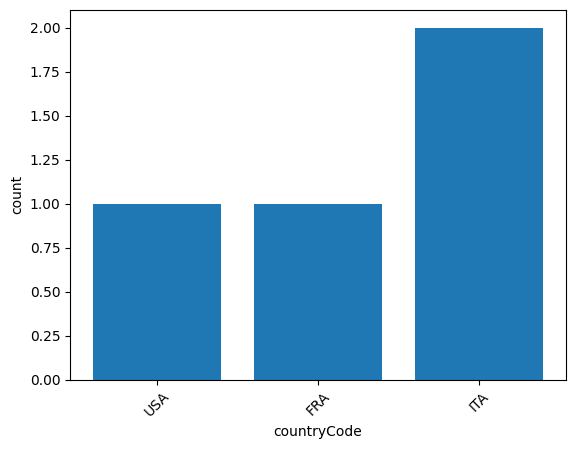

In [61]:
res_ = %sql SELECT COUNT(countryCode) AS count, countryCode FROM suppliers GROUP BY countryCode;

print (res_);

res_.bar();

The main strength of Relational DBs is the possibility of matching information from different tables through **Join** operations.

A join, either performed explicitly or implicitly is:

1. Computationally expensive. In the case of large databases, join operations might require a long time to execute.
2. Very easy to be done wrong, thus resulting in non-meaningful results.

Be sure of which attributes (most often keys) you are performing a join operation on.

#### Join the `supplier_to_product` table with the `suppliers` table 

In [62]:
%%sql

SELECT * 
FROM suppliers, supplier_to_product
WHERE supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1


In [63]:
%%sql

SELECT * 
FROM suppliers
INNER JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1


In [64]:
%%sql

SELECT * 
FROM suppliers
LEFT JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,None,None
3,Wild Hops,ITA,myemail@wildhops.it,None,None
4,Beer Paradise,ITA,beer@beerparadise.it,None,None


In [65]:
%%sql

SELECT * 
FROM suppliers
RIGHT JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1


We can concatenate multiple join operations to extract higher-level information out of the connections stored in the database.

#### Add the corresponding product names to the previous join

In [66]:
%%sql

SELECT * 
FROM suppliers
INNER JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID,productID,productName,unitPrice,unitsInStock,isDiscontinued
1,A hop in the park,USA,anewemail@ahop.com,2,1,2,Punk IPA,5.2,45,0
1,A hop in the park,USA,anewemail@ahop.com,3,1,3,HB Dunkel,4.5,250,0


The conjunction of `SELECT`, `GROUP BY`, and `JOIN` statements will allow us to extract non-trivial information out of any Relational database.

#### Add the following records to the `supplier_to_product` table, and perform the following queries:
    
| supplier | products provided |
| --- | --- | 
| "Wild Hops" | "Founders Porter", "Punk IPA", "HB Dunkel", "Damm Complot" |    
| "Beer Paradise" | "Punk IPA", "Damm Complot" |    
| "Allez Hops! Cave à bièr" | "Founders Porter", "HB Dunkel" |    

1. show all suppliers of "Damm Complot"
2. retrieve the email address of all possible suppliers of "Punk IPA"
3. list the unit price of all products supplied by Italian firms, listed in descending order (of unit price)  

In [67]:
sql_ = "INSERT INTO supplier_to_product (prodID, supID) VALUES (%s, %s)"
val_ = [
    # supplier Allez Hops
    (1, 2),
    (3, 2),

    # supplier Wild Hops
    (1, 3),
    (2, 3),
    (3, 3),
    (5, 3),

    # supplier Beer Paradise
    (2, 4),
    (5, 4),
]


dbc.executemany(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM supplier_to_product"); 
for _ in dbc:
     print(_)

(2, 1)
(3, 1)
(1, 2)
(3, 2)
(1, 3)
(2, 3)
(3, 3)
(5, 3)
(2, 4)
(5, 4)


In [68]:
%%sql

SELECT suppliers.supplierName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Punk IPA";

 * mysql+mysqlconnector://root:***@db
3 rows affected.


supplierName
A hop in the park
Wild Hops
Beer Paradise


In [69]:
%%sql

SELECT suppliers.email 
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Punk IPA";

 * mysql+mysqlconnector://root:***@db
3 rows affected.


email
anewemail@ahop.com
myemail@wildhops.it
beer@beerparadise.it


In [70]:
%%sql

SELECT DISTINCT products.unitPrice, products.productName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE suppliers.countryCode = "ITA"
ORDER BY unitPrice DESC;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


unitPrice,productName
5.2,Punk IPA
4.9,Founders Porter
4.5,HB Dunkel
3.7,Damm Complot


## 05 Queries on well-formed DBs

In MySQL, we can load entire databases from external files.

The files will contain the full database structure (tables and constraints) and will populate all tables with all records.

To load a database into the MySQL server from the interactive Docker shell, we can simply do the following:

1. Create a new database named `world`.
2. Import the content of the file `/mapd-workspace/dbs/world.sql` into the newly created database via:

```bash
$ mysql -u root -p world < /mapd-workspace/dbs/world.sql
```

**NB**: The `/mapd-workspace` directory has been defined as a Docker Volume and is a shared location with your computer.

#### Using the `world` DB, perform queries to answer the following questions.

Additional references can be found here https://dev.mysql.com/doc/world-setup/en/


Use a **single query** to answer the questions:

1. Which country has the largest population?
2. Get the total number of cities in Canada.
3. Select the country with the most cities.
4. List all the languages spoken in the Southeast Asia region.
5. Identify the 5 most spoken languages by number of countries.
6. What is the total population of the cities in the Caribbean region?
7. What Countries have a City named "Kingston"?
8. Plot the population density by country, limiting to the 25 with the least density.
9. Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with the highest GNP.
10. Create a scatter plot of the life expectancy vs the GNP of all countries that have Spanish as their Official language.


##### Suggestions:
- Start by inspecting the database tables' structure
- When in doubt, check the table content by selecting only a few lines (use `LIMIT` to avoid returning all records)
- Before finalizing the query, you can always perform "intermediate" queries to check if complex operations (e.g. `GROUP BY` and `JOIN`) are stated correctly

In [10]:
%%sql

USE world; 

SHOW TABLES;
DESCRIBE country;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
3 rows affected.
15 rows affected.


Field,Type,Null,Key,Default,Extra
Code,char(3),NO,PRI,,
Name,char(52),NO,,,
Continent,"enum('Asia','Europe','North America','Africa','Oceania','Antarctica','South America')",NO,,Asia,
Region,char(26),NO,,,
SurfaceArea,"decimal(10,2)",NO,,0.00,
IndepYear,smallint,YES,,None,
Population,int,NO,,0,
LifeExpectancy,"decimal(3,1)",YES,,None,
GNP,"decimal(10,2)",YES,,None,
GNPOld,"decimal(10,2)",YES,,None,


In [88]:
%%sql

SELECT COUNT(Code)
FROM country;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


COUNT(Code)
239


#### 1 - Which country has the largest population?

In [91]:
%%sql 

SELECT Population, Code 
FROM country
ORDER BY  Population DESC
LIMIT 1;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


Population,Code
1277558000,CHN


#### 2 - Get the total number of cities in Canada.

In [92]:
%%sql 

DESCRIBE city;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
ID,int,NO,PRI,None,auto_increment
Name,char(35),NO,,,
CountryCode,char(3),NO,MUL,,
District,char(20),NO,,,
Population,int,NO,,0,


In [95]:
%%sql 

SELECT COUNT(ID) AS CitiesInCanada /*usually better to count on the primary key*/
FROM city
WHERE CountryCode = "CAN";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


CitiesInCanada
49


#### 3 - Select the country with the most cities.

In [99]:
%%sql 

SELECT COUNT(ID) AS nCities, CountryCode
FROM city
GROUP BY CountryCode
ORDER BY nCities DESC
LIMIT 1;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


nCities,CountryCode
363,CHN


#### 4 - List all the languages spoken in the Southeast Asia region.

In [108]:
%%sql

DESCRIBE countrylanguage;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
CountryCode,char(3),NO,PRI,,
Language,char(30),NO,PRI,,
IsOfficial,"enum('T','F')",NO,,F,
Percentage,"decimal(4,1)",NO,,0.0,


In [11]:
%%sql

SELECT DISTINCT(region)
FROM country

 * mysql+mysqlconnector://root:***@db
25 rows affected.


region
Caribbean
Southern and Central Asia
Central Africa
Southern Europe
Middle East
South America
Polynesia
Antarctica
Australia and New Zealand
Western Europe


In [12]:
%%sql

SELECT DISTINCT language
FROM countrylanguage
INNER JOIN country ON countrylanguage.CountryCode = country.Code
WHERE country.Region = 'Southeast Asia';

 * mysql+mysqlconnector://root:***@db
47 rows affected.


language
Chinese
English
Malay
Malay-English
Bali
Banja
Batakki
Bugi
Javanese
Madura


#### 5 - Identify the 5 most spoken languages by number of countries.

In [1]:
%%sql 

SELECT *
FROM countrylanguage
LIMIT 10;

UsageError: Cell magic `%%sql` not found.


In [14]:
%%sql

SELECT Language, COUNT(countryCode) as nCountries
FROM countrylanguage
GROUP BY Language
ORDER BY DESC
LIMIT 5;

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'DESC
LIMIT 5' at line 4
[SQL: SELECT Language, COUNT(countryCode) as nCountries
FROM countrylanguage
GROUP BY Language
ORDER BY DESC
LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/f405)


LEt's do it with HAVING:

In [15]:
%%sql

SELECT Language, COUNT(countryCode) AS nCountries
FROM countrylanguage
WHERE IsOfficial='T'
GROUP BY Language
ORDER BY DESC
LIMIT 5;

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'DESC
LIMIT 5' at line 5
[SQL: SELECT Language, COUNT(countryCode) AS nCountries
FROM countrylanguage
WHERE IsOfficial='T'
GROUP BY Language
ORDER BY DESC
LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/f405)


#### 6 - What is the total population of the cities in the Caribbean region?

In [16]:
%%sql

DESCRIBE city

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
ID,int,NO,PRI,None,auto_increment
Name,char(35),NO,,,
CountryCode,char(3),NO,MUL,,
District,char(20),NO,,,
Population,int,NO,,0,


In [17]:
%%sql

DESCRIBE country

 * mysql+mysqlconnector://root:***@db
15 rows affected.


Field,Type,Null,Key,Default,Extra
Code,char(3),NO,PRI,,
Name,char(52),NO,,,
Continent,"enum('Asia','Europe','North America','Africa','Oceania','Antarctica','South America')",NO,,Asia,
Region,char(26),NO,,,
SurfaceArea,"decimal(10,2)",NO,,0.00,
IndepYear,smallint,YES,,None,
Population,int,NO,,0,
LifeExpectancy,"decimal(3,1)",YES,,None,
GNP,"decimal(10,2)",YES,,None,
GNPOld,"decimal(10,2)",YES,,None,


In [18]:
%%sql

SELECT DISTINCT Region
FROM country

 * mysql+mysqlconnector://root:***@db
25 rows affected.


Region
Caribbean
Southern and Central Asia
Central Africa
Southern Europe
Middle East
South America
Polynesia
Antarctica
Australia and New Zealand
Western Europe


In [19]:
%%sql

SELECT *
FROM country
JOIN city ON country.Code=city.CountryCode
WHERE country.Region="Caribbean";

 * mysql+mysqlconnector://root:***@db
58 rows affected.


Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2,ID,Name_1,CountryCode,District,Population_1
ABW,Aruba,North America,Caribbean,193.00,None,103000,78.4,828.00,793.00,Aruba,Nonmetropolitan Territory of The Netherlands,Beatrix,129,AW,129,Oranjestad,ABW,–,29034
AIA,Anguilla,North America,Caribbean,96.00,None,8000,76.1,63.20,None,Anguilla,Dependent Territory of the UK,Elisabeth II,62,AI,61,South Hill,AIA,–,961
AIA,Anguilla,North America,Caribbean,96.00,None,8000,76.1,63.20,None,Anguilla,Dependent Territory of the UK,Elisabeth II,62,AI,62,The Valley,AIA,–,595
ANT,Netherlands Antilles,North America,Caribbean,800.00,None,217000,74.7,1941.00,None,Nederlandse Antillen,Nonmetropolitan Territory of The Netherlands,Beatrix,33,AN,33,Willemstad,ANT,Curaçao,2345
ATG,Antigua and Barbuda,North America,Caribbean,442.00,1981,68000,70.5,612.00,584.00,Antigua and Barbuda,Constitutional Monarchy,Elisabeth II,63,AG,63,Saint John´s,ATG,St John,24000
BHS,Bahamas,North America,Caribbean,13878.00,1973,307000,71.1,3527.00,3347.00,The Bahamas,Constitutional Monarchy,Elisabeth II,148,BS,148,Nassau,BHS,New Providence,172000
BRB,Barbados,North America,Caribbean,430.00,1966,270000,73.0,2223.00,2186.00,Barbados,Constitutional Monarchy,Elisabeth II,174,BB,174,Bridgetown,BRB,St Michael,6070
CUB,Cuba,North America,Caribbean,110861.00,1902,11201000,76.2,17843.00,18862.00,Cuba,Socialistic Republic,Fidel Castro Ruz,2413,CU,2413,La Habana,CUB,La Habana,2256000
CUB,Cuba,North America,Caribbean,110861.00,1902,11201000,76.2,17843.00,18862.00,Cuba,Socialistic Republic,Fidel Castro Ruz,2413,CU,2414,Santiago de Cuba,CUB,Santiago de Cuba,433180
CUB,Cuba,North America,Caribbean,110861.00,1902,11201000,76.2,17843.00,18862.00,Cuba,Socialistic Republic,Fidel Castro Ruz,2413,CU,2415,Camagüey,CUB,Camagüey,298726


Final solution:

In [20]:
%%sql

SELECT SUM(city.Population)
FROM country
JOIN city ON country.Code=city.CountryCode
WHERE country.Region="Caribbean";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


SUM(city.Population)
11067550


#### 7 - What Countries have a City named "Kingston"?

In [78]:
%%sql

SELECT *
FROM country
JOIN  ON country.Code=city.CountryCode
WHERE city.Name="Kingston";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [ ]:
%%sql

SELECT DISTINCT country.Name
FROM country
JOIN  ON country.Code=city.CountryCode
WHERE city.Name="Kingston";

If you want to look for cities which have "Kingston" in the name, you modify the code as such:

In [ ]:
%%sql

SELECT DISTINCT country.Name
FROM country
JOIN  ON country.Code=city.CountryCode
WHERE city.Name LIKE "Kingston%";

#### 8 - Plot the population density by country, limiting to the 25 with the least density.

The population density is the total `Population` of a country divided by the `SurfaceArea`.
We can compute (and create as a new feature) this quantity on the fly during a `SELECT` statement and rename it with an `ALIAS` for convenience.

In [5]:
import matplotlib.pyplot as plt

In [6]:
%%sql

SELECT Name, Population/SurfaceArea AS Density
FROM country
ORDER BY Density ASC
LIMIT 25;

UsageError: Cell magic `%%sql` not found.


In [79]:
res_ = %sql SELECT Name, Population/SurfaceArea AS Density FROM country ORDER BY Density ASC LIMIT 25;;

print(res_)

plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'FROM ORDER BY LIMIT' at line 1
[SQL: SELECT FROM ORDER BY LIMIT ;]
(Background on this error at: https://sqlalche.me/e/20/f405)
None


AttributeError: 'NoneType' object has no attribute 'bar'

<Figure size 1600x300 with 0 Axes>

#### 9 - Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with the highest GNP

We can use `BETWEEN a AND b` to select only those entries between two extremes;

In [ ]:
%%sql

SELECT Name, GNP
FROM country
WHERE IndepYear BETWEEN 1850 AND 1910
ORDER BY GNP DESC
LIMIT 10;

In [ ]:
res_ = %sql SELECT Name, GNP FROM country WHERE IndepYear BETWEEN 1850 AND 1910 ORDER BY GNP DESC LIMIT 10;

print(res_)

plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

#### 10 - Create a scatter plot of the life expectancy vs the GNP of all countries that have Spanish as their Official language

In [ ]:
%%sql

SELECT LifeExpenctancy, GNP, country.Name
FROM country
RIGHT JOIN countrylanguage ON country.Code=countrylanguage.CountryCode
WHERE Language="Spanish" 
AND IsOfficial="T";

In [ ]:
res_ = %sql SELECT  LifeExpenctancy, GNP, country.Name\
            FROM  country\
            RIGHT JOIN countrylanguage ON country.Code=countrylanguage.CountryCode\
            WHERE Language="Spanish" \
            AND IsOfficial="T";

print(res_)

plt.figure(figsize=(8,6))
for _ in res_:
    plt.scatter(_[0],_[1],s=50);
    plt.annotate(_[2], (float(_[0])*1.002,float(_[1])*1.002));
plt.ylabel('GNP')
plt.xlabel('LifeExpectancy')


## 06 More on queries 

Let's import a well-structured database, with several tables and relationships, to be used as a sandbox for further exercises on queries.

The database is freely available and is taken from the IMDb (Internet Movie Database) website (https://www.imdb.com/interfaces/), although severely slimmed down.

This database contains several tables with information about movies, TV shows, people involved in the entertainment industry, and more, spanning from the 1890s to recent years.

To simplify the execution of queries, we will work with a slimmed-down version of the entire database, with still plenty of records for us to extract interesting information.

To start working with the IMDb database, we need to import it into our environment. The database `.sql` file should be downloaded from the link on Moodle and copied into the `/mysql/dbs` folder of the GitHub repository so that it will be found in the mounted volume at the location: `/mapd-workspace/dbs/IMDb_pruned.sql`.

1. Create a new DB named `IMDb`
2. Import the content of the file `/mapd-workspace/dbs/IMDb_pruned.sql` into the newly created DB
(this might take a minute or two...)

### Check which tables are available

In [ ]:
%%sql 

USE IMDb
SHOW TABLES;

### Describe the content of table `Names_`

name_id is actually a primary key, but it's not shown for reasons that can be seen at the link above.

In [ ]:
%%sql

DESCRIBE Names_

### Study the distribution of the year of birth of all people included in the database

1. Start by limiting the query to 1000 entries
    1. Draw a histogram of the year of birth
    1. Draw a second histogram with the year of birth of the 1000 youngest people in the list

In [ ]:
# 1.A



In [ ]:
# 1.B


2. Extend the query to all records in the table
    1. Check for outliers (inspect min and max)
    2. If any outlier is found, limit the query to a reasonable range (say... at least people born after 1850)
    3. Draw a new histogram with the year of birth
    4. Compute the mean and standard deviation of the year of birth

In [ ]:
# 2.A


In [ ]:
# 2.B


In [ ]:
# 2.C


In [ ]:
# 2.D


### Movie stats

1. Plot the number of titles available in the database for each year over the past 25 years.
2. List the names of all actors who have portrayed the character Spider-Man in movies, along with the corresponding movie titles.
3. List and count the top 10 people who have appeared the most in movies directed by Wes Anderson.

#### 1 - Plot the number of titles available in the database for each year over the past 25 years.

#### 2 - List the names of all actors who have portrayed the character Spider-Man in movies, along with the corresponding movie titles.

#### 3 - List and count the top 10 people who have appeared the most in movies directed by Wes Anderson.

### Is IMDB only about movies? 

1. Check the number of different media types contained in the database
2. Plot a histogram summarizing the number of titles per media type
3. Find the name and rating of the oldest videogame stored in the database 

#### 1 - Check the number of different media types contained in the database

#### 2 - Plot a histogram summarizing the number of titles per media type

#### 3 - Find the name and rating of the oldest videogame stored in the database 

### Identify interesting outliers 

1. List the names of all movies whose titles begin with "The" and have a runtime between 3 and 4 hours.
2. What actor had the most roles as 'Self'?
3. Identify what TV series had more than 1,000 episodes, and identify in what year it was aired the first- and last-episode

#### 1 - List the names of all movies whose titles begin with "The" and have a runtime between 3 and 4 hours.

#### 2 - What actor had the most roles as 'Self'?

#### 3 - Identify what TV series had more than 1,000 episodes, and identify in what year it was aired the first- and last-episode

### It's all about the ratings 

1. Group all movies by decade and plot their overall rating distribution trend. Limit the query to the movies with at least 1000 ratings.
2. Plot the average rating of each episode of "Games of Thrones". Group by season and compute the average and standard deviation for each season
3. Plot the total number of movies produced per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

#### 1 - Group all movies by decade and plot their overall rating distribution trend. Limit the query to the movies with at least 1000 ratings.

#### 2 - Plot the average rating of each episode of "Games of Thrones". Group by season and compute the average and standard deviation for each season.

#### 3 - Plot the total number of movies produced per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre